In [104]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.5em; }
</style>

In [105]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
from scipy import fftpack
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams, patches
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='500px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

### Universidad Austral de Chile 

## INFO183: Análisis de sistemas lineales

# Unidad 3: Sistemas para el procesamiento de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Definición de sistema](#section1)
1. [Sistemas LTI y filtros](#section2)

***
[Volver al índice](#index)
<a id="section1"></a>

# Definición de sistema

***

- *Análisis de señales:* El estudio de las señales y sus propiedades en el dominio del tiempo y frecuencia
- *Procesamiento de señales:* El diseño de **sistemas** que procesan **señales de entrada** y producen **señales de salida**
    - Adicionalmente, un sistema puede tener parámetros (entradas númericas o booleanas)
    - Adicionalmente, un sistema puede tener retornos (salidas númericas o booleanas)
    - Sistema sin señal de entrada: Oscilador
    - Sistema sin señal de salida: Detector/clasificador de señal
    - Existen sistemas analógicos (continuos) y digitales (discretos), nos enfocaremos en los últimos
    
   
<center><img src="img/system.png"></center>

- Usaremos $x[n]$ para denotar la señal (discreta) de entrada y $X[k]$ su espectro
- Usaremos $y[n]$ para denotar la señal (discreta) de salida e $Y[k]$ su espectro
 


### Ejemplos

1. Un sistema para reducir el ruido de una EEG

<center><img src="img/system-denoise-eeg.png"></center>

1. Un sistema para mejorar (sharpen) una imagen fuera de foco

<center><img src="img/system-sharpen.jpg"></center>

1. Un sistema para eliminar el eco de un audio

<center><img src="img/system-echo.png"></center>


***

# Sistemas  sin memoria

Los sistemas sin memoria son de forma

$$
y[n] = f(x[n]),
$$

es decir la salida del sistema en un instante dado depende solo de la entrada en ese instante

### Ejemplos


- Sistema amplificador ideal 
$$
y[n] = A x[n], 
$$
donde $A$ se llama *ganancia*
    - provoca atenuación de la entrada si $A<1$
    - es un sistema identidad si $A=1$

- Sistema con corrupción cuadrática
$$
y_n = x_n + \epsilon x_n^2
$$

- Sistema saturador
$$
y_n = \text{sign}(x_n)
$$
- Sistema rectificador
$$
y_n = | x_n |
$$

<IPython.core.display.Javascript object>


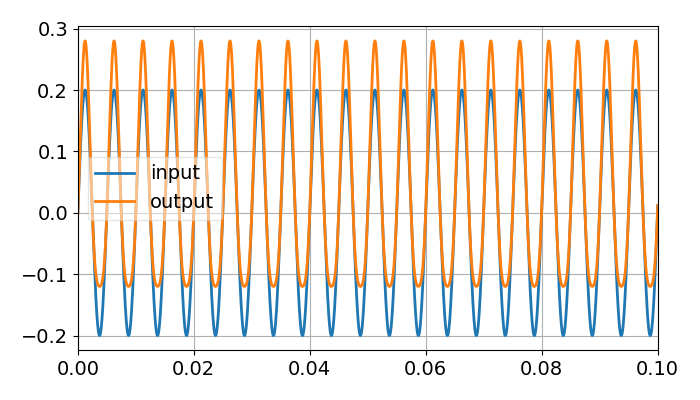

In [2]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
Fs = 22050
n = np.arange(0, 2, step=1.0/Fs)
x = 0.2*np.sin(2.0*np.pi*200*n); 
y = x + 2*x**2
ax.plot(n, x, label='input'); ax.plot(n, y, label='output'); 
ax.set_xlim([0, 0.1]); plt.legend()
Audio(np.concatenate((y, [1, -1])), rate=Fs)

***

# Sistema Lineal

Propiedades de los sistemas lineales

- **Homogeneidad:** Un cambio en la amplitud de la entrada produce un cambio equivalente en la salida

$$
f(cx[n]) = c f(x[n]) = c y[n]
$$

- **Aditividad:** Señales que se suman en la entrada producen señales que se suman en la salida

$$
f(x_1[n] + x_2[n]) = f(x_1[n]) + f(x_2[n]) = y_1[n] + y_2[n]
$$

    - Las señales pasan por el sistema sin interactuar entre ellas
- Si no se cumple alguna de estas propiedades el sistema es **no lineal**
- ¿Son los sistemas anteriores lineales?



### Otras propiedades de los sistemas lineales


- Una cascada de sistemas lineales forman un sistema lineal equivalente
    - Conmutatividad: El orden de los sistemas en la cascada no es relevante
<img src="img/system-conmu.png" width="400px">

- **Principio de superposición**: 
    - Si descomponemos una señal en $M$ componentes: $x[n] = x_1[n] + x_2[n] + \ldots +  x_M[n]$
    - Y aplicamos un sistema lineal a cada componente $y_j[n] = f(x_j[n])$
    - Podemos recuperar la salida total como $y_1[n] + y_2[n] + \ldots +  y_M[n] = y[n]$

<img src="img/system-superpos.png" width="400px">

***

# Sistemas con memoria

Un sistema con memoria es aquel cuya salida puede depender de 
- la entrada actual
- las entradas anteriores
- las salidas anteriores

$$
y[n] = f(x[n], x[n-1], \ldots, x[0], y[n-1], y[n-2], \ldots y[0]),
$$

esto también se conoce como **sistema causal**

### Ejemplos de sistemas lineales con memoria

- Sistema con retardo (delay)

$$
y[n] = x[n-m],
$$
    - depende solo de una entrada "pasada"
    - el valor de m define que tan "antigua" es la entrada pasada

- Sistema reverberador (eco)

$$
y[n] = x[n] + A x[n-m],
$$

    - depende de una entrada "pasada" y la entrada actual
    - la ganancia controla si el eco es atenuado o amplificado

- El delay no afecta la amplitud de los componentes frecuenciales pero si su fase
- Más adelante veremos que este es un tipo de filtro conocido como pasa-todo (*all-pass*)

<IPython.core.display.Javascript object>


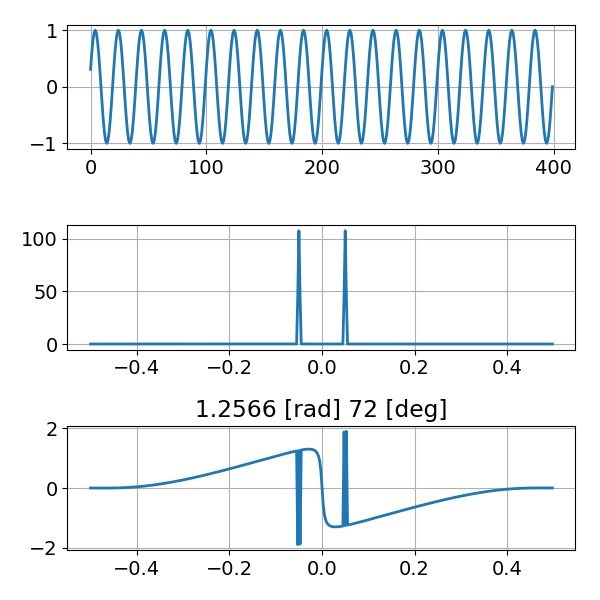

interactive(children=(IntSlider(value=0, continuous_update=False, description='m', layout=Layout(height='20px'…

In [108]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
n = np.arange(0, 400, step=1)
x = lambda m: np.sin(2.0*np.pi*20*(n-m)/len(n)) 
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))
def update(m):
    ax[0].cla(); ax[0].plot(n, x(m));
    X = fftpack.fftshift(fftpack.fft(x(m)*scipy.signal.hamming(len(n))))
    ax[1].cla(); ax[1].plot(f, np.absolute(X))
    ax[2].cla(); ax[2].plot(f, np.angle(X)); 
    angle_delay = np.angle(X)[np.argmax(np.absolute(X))]
    ax[2].set_title("%0.4f [rad] %0.0f [deg]" % (angle_delay, 180*angle_delay/np.pi))

interact(update, m=IntSlider_nice(min=0, max=20));

<IPython.core.display.Javascript object>


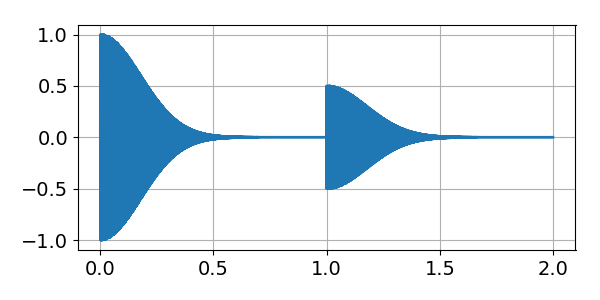

In [117]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))
n = np.arange(0, 2, step=1.0/22050)
x = lambda m: np.sin(2.0*np.pi*880*(n-m))*np.exp(-(n-m)**2/0.25**2)*np.heaviside(n-m, 0)
y = x(0) + 0.5*x(1.)
#y = np.array([(2-k)*x(k) for k in [0, 0.25, 0.5, 0.75]]).sum(0)
ax.plot(n, y);
Audio(y, rate=22050)

- El eco en cambio si modifica el espectro de magnitud
- Notemos el efecto de interferencia constructiva y destructiva al modificar el retardo

<IPython.core.display.Javascript object>


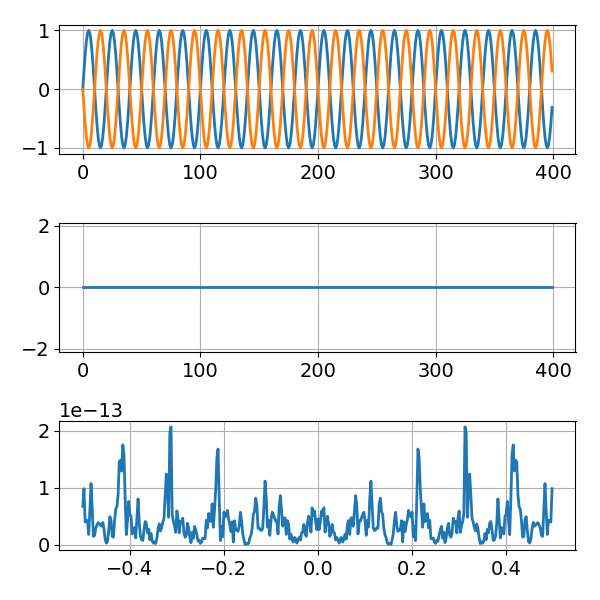

interactive(children=(IntSlider(value=0, continuous_update=False, description='m', layout=Layout(height='20px'…

In [118]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
n = np.arange(0, 400, step=1)
x = lambda m: np.sin(2.0*np.pi*20*(n-m)/len(n)) 
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))

def update(m, A):
    y = x(0) + A*x(m)
    ax[0].cla(); ax[0].plot(n, x(0), n, A*x(m))
    ax[1].cla(); ax[1].plot(n, y); ax[1].set_ylim([-A-1.1, A+1.1])
    X = fftpack.fftshift(fftpack.fft(y*scipy.signal.hamming(len(n))))
    ax[2].cla(); ax[2].plot(f, np.absolute(X)); 
    #ax[2].set_ylim([-0.1, (A+1)/2 + 0.2])
interact(update, m=IntSlider_nice(min=0, max=20), 
         A=SelectionSlider_nice(options=[0.5, 1., 2.], value=1));

***

# Sistema FIR 

Generalizando el ejemplo de sistema lineal reverberante a más retardos llegamos a 

$$
\begin{align}
y[n] &= h[0] x[n] + h[1] x[n-1] + h[2] x[n-2] + \ldots + h[L] x[n-L] \nonumber \\
&= \sum_{j=0}^{L} h[j] x[n-j] \nonumber \\
&= (h* x)[n] \nonumber 
\end{align}
$$

que se puede modelar como una convolución discreta o en pseuco-código como un ciclo iterativo
```
   y[n] = 0
   for j in 0 to L
       y[n] = y[n] + h[j] x[n-j]
```
y se conoce como


- sistema FIR (finite impulse response)
- sistema MA (moving average)
- sistema todo-zeros 


y es de orden L (posee L+1 coeficientes)

- ¿Es este sistema lineal?
- ¿Que ocurre si entra al sistema un impulso unitario?

## Respuesta al impulso

Sea el impulso unitario o delta de Kronecker
$$
\delta[n-m] = \begin{cases} 1 & n=m \\ 0 & n \neq m \end{cases}
$$

La **respuesta al impulso de un sistema discreto** es la salida obtenida cuando la entrada es un impulso unitario

Para el sistema FIR tenemos

$$
y[n] = (h * \delta)[n] = \sum_{j=0}^L h[j] \delta[n-j] = \begin{cases} h[n] & n \in [0, L] \\ 0 & \text{en otro caso} \end{cases} \\
$$

es decir la respuesta al impulso tiene una duración finita y luego decae a zero

Notemos que la respuesta al impulso recupera los coeficientes $h[j]$ del sistema


## Respuesta en frecuencia

La **respuesta en frecuencia de un sistema** es la salida que se obtiene al aplicar una entrada sinusoidal  $e^{j \frac{2\pi}{N} kn }$ 

La respuesta en frecuencia es la DFT de la respuesta al impulso 

$$
H[k] = \sum_{n=0}^{N-1} h[n] e^{-j \frac{2\pi}{N} kn }
$$

Por ejemplo para el caso del eco teniamos

$$
y[n] = x[n] + A x[n-m]
$$

Es decir que $h[n] = \delta[n] + A \delta[n-m]$ y por ende

$$
H[k] = 1 +  A e^{-j \frac{2\pi}{N} km }
$$

y

$$
|H[k]| = 2 + 2 A \cos \left(\frac{2\pi}{N} km \right) 
$$

<IPython.core.display.Javascript object>


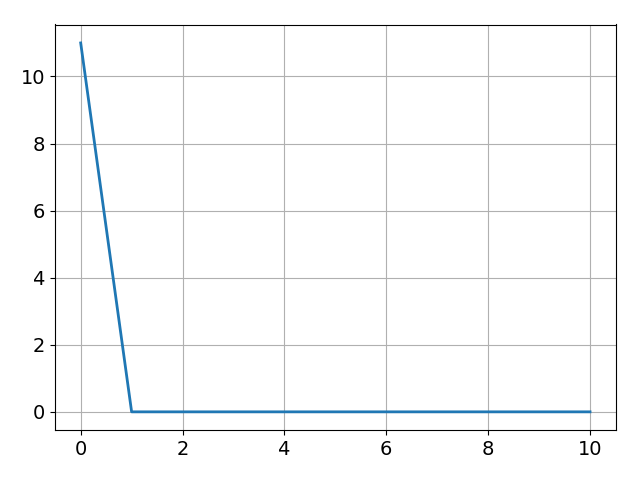

/usr/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [83]:
plt.close('all'); plt.figure()
h = np.ones(shape=(11)); 
plt.plot((fftpack.fft(h, n=len(h))));
#plt.plot(2+ 2*np.cos(2*np.pi*np.arange(0, 1000)*5/1000))

## Intepretación como media movil (MA)

- El sistema FIR es equivalente a una media movil ponderada (*moving average*)
- los coeficientes del filtro son los ponderadores 

Por ejemplo sea un sistema de 3 coeficientes unitarios
$$
\begin{align}
y[n] = (h*x)[n] &= \sum_{j=0}^{2} h[j] x[n-j] \nonumber \\
&= x[n] + x[n-1] + x[n-2] \nonumber
\end{align}
$$
donde cada salida se calcula a partir de 
$$
\overbrace{x[0], x[1], x[2]}^{y[2]} , x[3], x[4], \ldots
$$
$$
x[0], \overbrace{x[1], x[2] , x[3]}^{y[3]}, x[4], \ldots
$$
$$
x[0], x[1], \overbrace{x[2] , x[3], x[4]}^{y[4]}, \ldots
$$

Este tipo de sistema promediador puede usarse para eliminar ruido aditivo

<IPython.core.display.Javascript object>


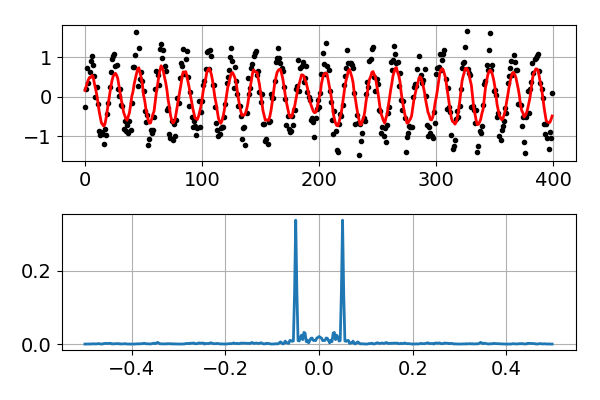

interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [100]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4))
n = np.arange(0, 400, step=1)
x = np.sin(2.0*np.pi*20*n/len(n)) + 0.25*np.random.randn(len(n))
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))
def update(L):
    y = np.convolve(x, np.ones(shape=(L,))/L, mode='same')
    ax[0].cla(); ax[0].plot(n, x, 'k.', n, y, 'r-'); 
    X = fftpack.fftshift(fftpack.fft(y*scipy.signal.hamming(len(n))))
    ax[1].cla(); ax[1].plot(f, 2*np.absolute(X)/len(n)); 
interact(update, L=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 15, 20]));

# Sistemas puramente retro-alimentados

Son aquellos sistemas cuya salida depende solo de 
- el valor presente de la entrada
- los valores anteriores de la salida

es decir

$$
y[n] = x[n] + \sum_{j=1}^M h[j] y[n-j]
$$

También se conoce sistema autoregresivo (AR)

Este sistema se modela como una recursión

# Sistema IIR (infinite impulse response)

Generalizando el ejemplo de sistema FIR para incluir versiones pasadas de la salida llegamos a 

$$
\begin{align}
y[n] &= a_0 x[n] + a_1 x[n-1] + a_2 x[n-2] + \ldots + a_{L} x[n-L]  \nonumber \\
& + b_1 y[n-1] + b_2 y[n-2] + \ldots + b_M y[n-M] \nonumber \\
&= \sum_{j=0}^{L} a_j x[n-j] + \sum_{j=1}^{M} b_j y[n-j]  \nonumber 
\end{align}
$$

que se puede modelar como dos convoluciones discretas


- sistema IIR (infinite impulse response)
- sistema ARMA (auto-regresive moving average)

y es de orden L (posee L+1 coeficientes)

- ¿Es este sistema lineal?
- ¿Que ocurre si entra al sistema un impulso unitario?

...

***

# Sistema invariante al desplazamiento

***
Un sistema es invariante al desplazamiento  (*shift-invariant*) de su entrada si 

$$
f(x[n-m]) = y[n-m] 
$$

Es decir que 
- Aplicar un retardo en la entrada provoca un retardo equivalente en la salida
- Las características del sistema no cambian con $n$
- Un *blip* en la entrada produce un *blop* en la salida sin importar **cuando** ocurre el blip
- Cuando el índice $n$ representa el tiempo decimos que el sistema es **invariante en el tiempo**

¿Son los sistemas FIR e IIR invariantes al desplazamiento?




<IPython.core.display.Javascript object>


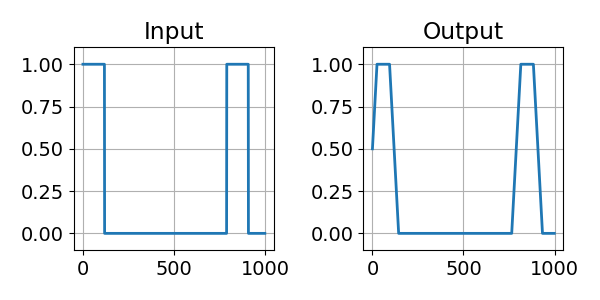

interactive(children=(SelectionSlider(continuous_update=False, description='m', layout=Layout(height='20px', w…

In [103]:
plt.close('all'); fig, ax = plt.subplots(1, 2, figsize=(6, 3))
n = np.arange(0, 1000)
l0 = ax[0].plot(n, np.zeros_like(n)); 
ax[0].set_ylim([-0.1, 1.1]); ax[0].set_title('Input')
l1 = ax[1].plot(n, np.zeros_like(n));
ax[1].set_ylim([-0.1, 1.1]); ax[1].set_title('Output')

def update(m, L):
    x = 0.5 + 0.5*scipy.signal.square((n-m)/(2.*np.pi*20), duty=0.15) 
    filt = np.ones(shape=(L, ))/L
    l0[0].set_ydata(x); l1[0].set_ydata(scipy.signal.convolve(x, filt, mode='same'))

interact(update, m=SelectionSlider_nice(options=[0, 10, 20, 50, 100]),
         L=SelectionSlider_nice(options=[50, 100, 200]));

***
[Volver al índice](#index)
<a id="section2"></a>

# Sistema LTI y Filtros
***

Los sistemas LTI (*linear time-invariant*) son lineales e invariantes al desplazamiento de la entrada

Cuando un sistema LTI tiene una señal de entrada y una señal de salida lo llamamos **filtro**

La salida del filtro se denomina usualmente señal filtrada

Los filtros se expresan como una convolución

$$
y[n] = (h * x)[n] = \sum_m h[m] x[n-m]
$$

Por ende cumplen que

$$
Y[k] = X[k] H[k] ,
$$

donde $H[k]$ es la DFT del filtro

- El filtro actua como una mascara que modifica el espectro de la entrada
- Solo puede acentuar, atenuar o remover ciertas frecuencias pero nunca crear nuevas 

Consideremos los siguienes filtros ideales

<img src="img/ideal_filters.gif">

***

# Contenidos de la unidad

***

1. Detección y comparación de señales
1. Espectro de potencia y Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener

***
[Volver al índice](#index)

<a id="section1"></a>

# Detección y comparación de señales en el tiempo

***

